In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn import preprocessing
import math

import warnings

warnings.filterwarnings("ignore")

Some Trash
===

In [2]:
class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def int_r(array):
    result = []
    for num in array:
        num = int(num + (0.5 if num > 0 else -0.5))
        result.append(num)
    return np.array(result)

In [3]:
torch.manual_seed(0)
np.random.seed(0)


Settings
===

In [4]:
args = {
    
    'seq_len':  5,
    'hidden_size': 20,
    'lr': 0.01,
    'batch_size': 1,
}

args = dotdict(args)

Dataset part
===

Фиббоначи

In [5]:
test_seq1 = [1, 1]
fib1 = 1
fib2 = 1

s1_n = 30

i = 0
while i < s1_n - 2:
    fib_sum = fib1 + fib2
    fib1 = fib2
    fib2 = fib_sum
    i += 1
    test_seq1.append(fib2)
    
test_seq1 = np.array(test_seq1)

In [6]:
#test_seq1 = np.arange(1, 100)
test_seq1

array([     1,      1,      2,      3,      5,      8,     13,     21,
           34,     55,     89,    144,    233,    377,    610,    987,
         1597,   2584,   4181,   6765,  10946,  17711,  28657,  46368,
        75025, 121393, 196418, 317811, 514229, 832040])

Факториал

In [7]:
test_seq2 = []

s2_n = 30

for i in range(s2_n):
    test_seq2.append(math.factorial(i))
    
test_seq2

[1,
 1,
 2,
 6,
 24,
 120,
 720,
 5040,
 40320,
 362880,
 3628800,
 39916800,
 479001600,
 6227020800,
 87178291200,
 1307674368000,
 20922789888000,
 355687428096000,
 6402373705728000,
 121645100408832000,
 2432902008176640000,
 51090942171709440000,
 1124000727777607680000,
 25852016738884976640000,
 620448401733239439360000,
 15511210043330985984000000,
 403291461126605635584000000,
 10888869450418352160768000000,
 304888344611713860501504000000,
 8841761993739701954543616000000]

Переодическая

In [8]:
test_seq3 = []

s3_n = 30

for i in range(s3_n):
    test_seq3.append(math.sin(i))
    
test_seq3

[0.0,
 0.8414709848078965,
 0.9092974268256817,
 0.1411200080598672,
 -0.7568024953079282,
 -0.9589242746631385,
 -0.27941549819892586,
 0.6569865987187891,
 0.9893582466233818,
 0.4121184852417566,
 -0.5440211108893698,
 -0.9999902065507035,
 -0.5365729180004349,
 0.4201670368266409,
 0.9906073556948704,
 0.6502878401571168,
 -0.2879033166650653,
 -0.9613974918795568,
 -0.750987246771676,
 0.14987720966295234,
 0.9129452507276277,
 0.8366556385360561,
 -0.008851309290403876,
 -0.8462204041751706,
 -0.9055783620066239,
 -0.13235175009777303,
 0.7625584504796027,
 0.956375928404503,
 0.27090578830786904,
 -0.6636338842129675]

Степенная

In [9]:
test_seq4 = []

s4_n = 30

for i in range(s4_n):
    test_seq4.append(2 ** i)
    
test_seq4

[1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 256,
 512,
 1024,
 2048,
 4096,
 8192,
 16384,
 32768,
 65536,
 131072,
 262144,
 524288,
 1048576,
 2097152,
 4194304,
 8388608,
 16777216,
 33554432,
 67108864,
 134217728,
 268435456,
 536870912]

In [10]:
class ClipDataset(Dataset):
    def __init__(self, sequence=None, is_float=False, seq_len=args.seq_len):  
        if type(sequence) is list:
            sequence = np.array(sequence)
        
        assert sequence.ndim == 1
        self.sequence = sequence
        self.is_float = is_float
        self.seq_len = seq_len
        
        self.transformer = preprocessing.QuantileTransformer(random_state=0)
        self.normalize()
        

    def __len__(self):
        return self.sequence.shape[0] - (self.seq_len + 1)
    
    
    def normalize(self):
        X_train_trans = self.transformer.fit_transform(self.sequence.reshape(-1, 1))
        self.sequence = X_train_trans.flatten()
        
        
        
    def denormalize(self, values_array):
        if type(values_array) is int or type(values_array) is float:
            values_array = [values_array]
            
        if type(values_array) is list:
            values_array = np.array(values_array)
            
        values_array = values_array.reshape(-1, 1)
        
        result = self.transformer.inverse_transform(values_array).flatten()
        
        
        return int_r(result) if self.is_float==False else result
        
        
    def __getitem__(self, i):
        
        clip_start = i
        clip_end = i+self.seq_len 
        x = self.sequence[clip_start:clip_end]
        y = self.sequence[clip_end]
        
        #clip_start = i+1
       # clip_end = i+1+args.seq_len 
        #x1 = self.sequence[clip_start:clip_end]
        #y1 = self.sequence[clip_end]
        
        
        return x, y#, x1, y1

In [11]:
b = ClipDataset(test_seq1)
b.__getitem__(0)

(array([0.        , 0.        , 0.06896552, 0.10344828, 0.13793103]),
 0.1724137931034483)

In [12]:
b.denormalize(0.10526316)

array([3])

In [13]:
len(b)

24

Model part
====

In [14]:
class Model(nn.Module):
    def __init__(self, num_features, hidden_size, num_targets):
        super(Model, self).__init__()
        
        self.dense1 = nn.Linear(num_features+hidden_size, hidden_size)        
        
        self.dense2 = nn.Linear(hidden_size, num_targets)
        
    
    def forward(self, x, prev_hidden):
        #print(x.shape)
        x = torch.cat((x, prev_hidden), 1)
       # print(x.shape)
        
        hidden = self.dense1(x)   
        
        ouput = self.dense2(hidden)       
        
        return ouput, hidden

Train part
===

In [15]:
def MAPE(pre, gt):
    pre = pre.detach()+0.001
    gt = gt.detach()+0.001
    result = abs((gt - pre) / gt).mean()
    
    return result.item()

In [16]:
class Trainer():
    def __init__(self, sequence=None, is_float=False, lr=args.lr, seq_len=args.seq_len):        
        self.lr = lr
        self.seq_len = seq_len
        self.model = Model(self.seq_len, args.hidden_size, 1)
        
       # split = int(test_seq1.shape[0]*0.7)
        self.dataset = ClipDataset(sequence, is_float=is_float, seq_len=self.seq_len)
        self.train_loader = DataLoader(self.dataset, batch_size=args.batch_size, shuffle=False)
        
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr )
        
        self.criterion = nn.MSELoss()
        
        self.train_loss = []
        self.train_metric = []

        
    def training(self, epoch):
        self.model.train()
        #tbar = tqdm(self.train_loader)
        num_img_tr = len(self.train_loader)
        
        epoch_loss = []
        epoch_metric = []
        
        prev_hidden = torch.zeros(args.batch_size, args.hidden_size)
        for i, sample in enumerate(self.train_loader):
            x, y = sample[0].float(), sample[1].float()
            
            self.optimizer.zero_grad()
            
            output, prev_hidden = self.model(x, prev_hidden)
            prev_hidden = prev_hidden.detach()
            
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()
            
            epoch_loss.append(loss.item())
            epoch_metric.append(MAPE(output, y))
            #print(output, y, MAPE(output, y))
            
        
        epoch_metric = np.array(epoch_metric).mean()
        self.train_metric.append(epoch_metric)
        
        epoch_loss = np.array(epoch_loss).mean()
        self.train_loss.append(epoch_loss)
        
        return epoch_loss, epoch_metric
        
        
    def test(self):
        prev_hidden = torch.zeros(args.batch_size, args.hidden_size)
        for i, sample in enumerate(self.train_loader):
            x, y = sample[0].float(), sample[1].float()
            
            with torch.no_grad():                
                output, prev_hidden = self.model(x, prev_hidden)
                prev_hidden = prev_hidden.detach()
              
            #print(x)
            #print(output)    
                
            print(self.dataset.denormalize(x[0]))                   
            print(self.dataset.denormalize([output[0]]))
                
            #if i == 5:
            #    break

RESLUTS
====

In [37]:
target_mape = 0.01
max_epoch = 1000
working_dpi = 180

In [18]:
def experiment(*args, **kwargs):
    trainer = Trainer(*args, **kwargs)
    
    loss = 9999999
    mape = 1
    
    epoch = 0
    while mape > target_mape:
        loss, mape = trainer.training(epoch)
        epoch += 1  
        
        if epoch == max_epoch:
            break

    
    return trainer.train_loss, trainer.train_metric

In [19]:
def plot_loss(data, name, log=True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=working_dpi)


    ax.plot(data)
    if log:
        ax.set_yscale('log')

    ax.set_title(name)
    ax.set_ylabel('Ошибка')
    ax.set_xlabel('Количество эпох')


    plt.show()

1) Фиббоначи
==

In [20]:
fib_loss, fib_metric = experiment(test_seq1)

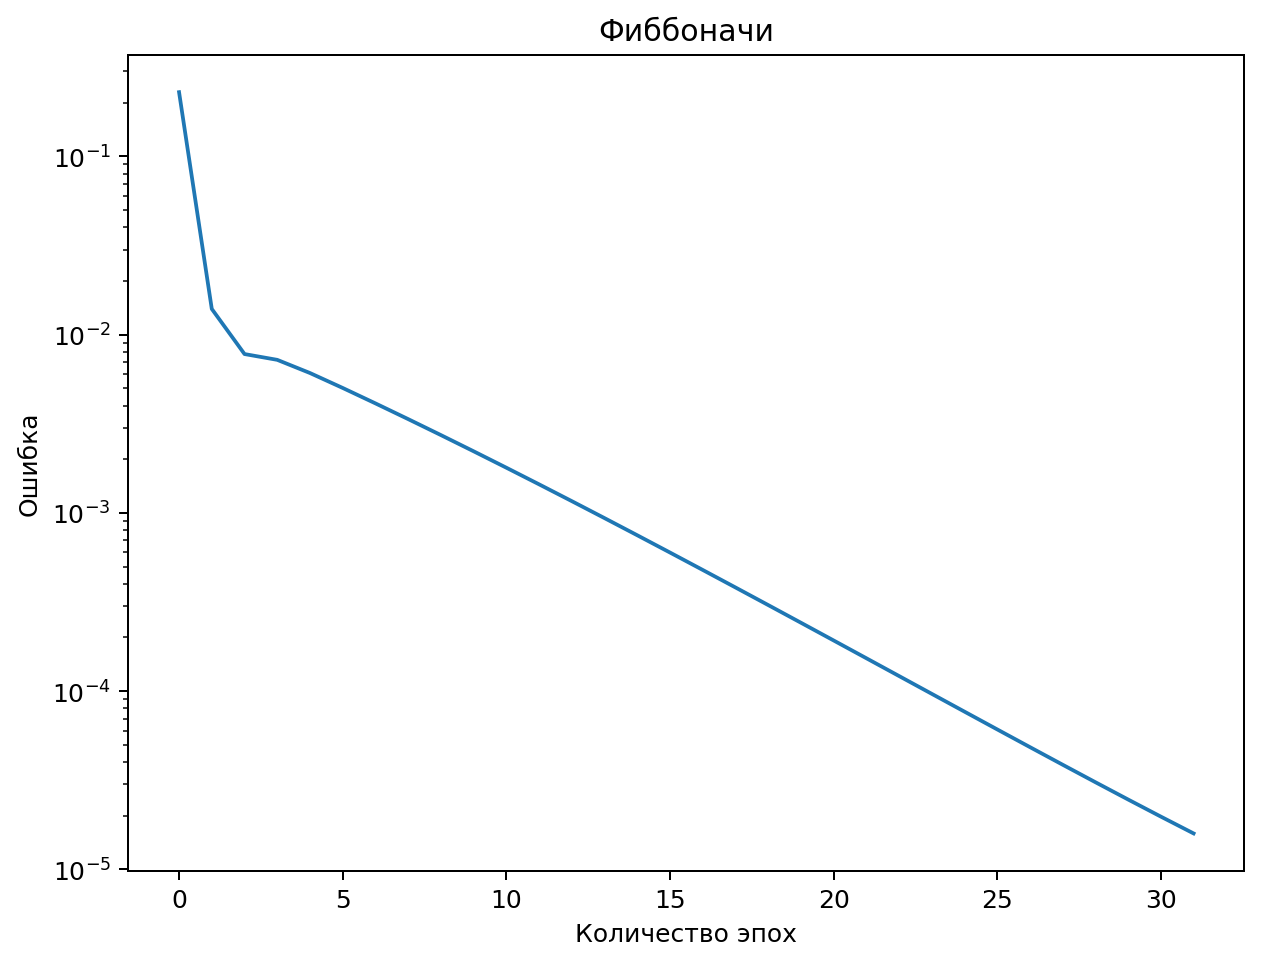

In [38]:
plot_loss(fib_loss, name='Фиббоначи')

2) Факториал
==

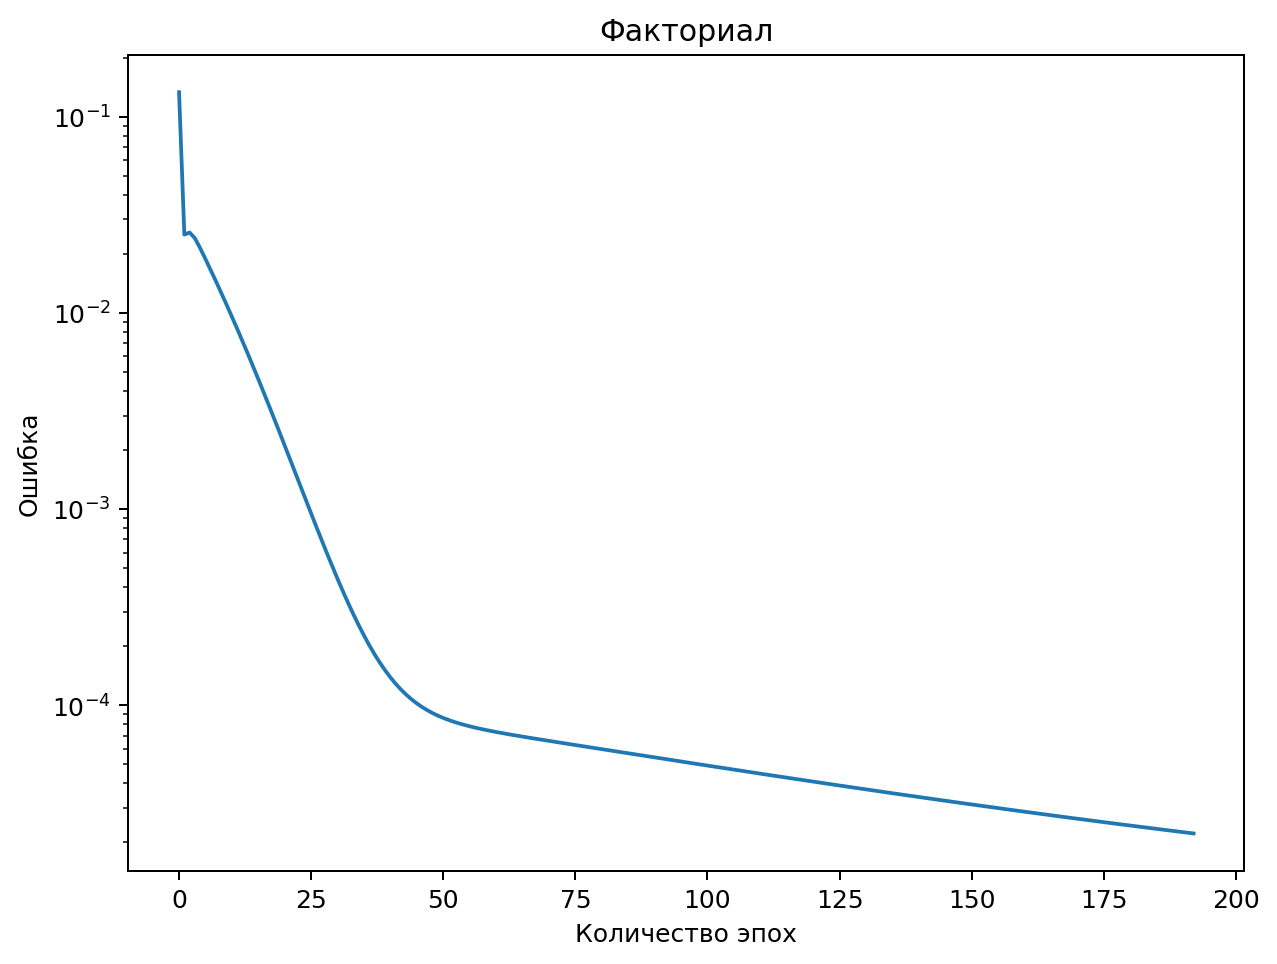

In [39]:
fac_loss, fac_metric = experiment(test_seq2)
plot_loss(fac_loss, name='Факториал')

3) Период
==

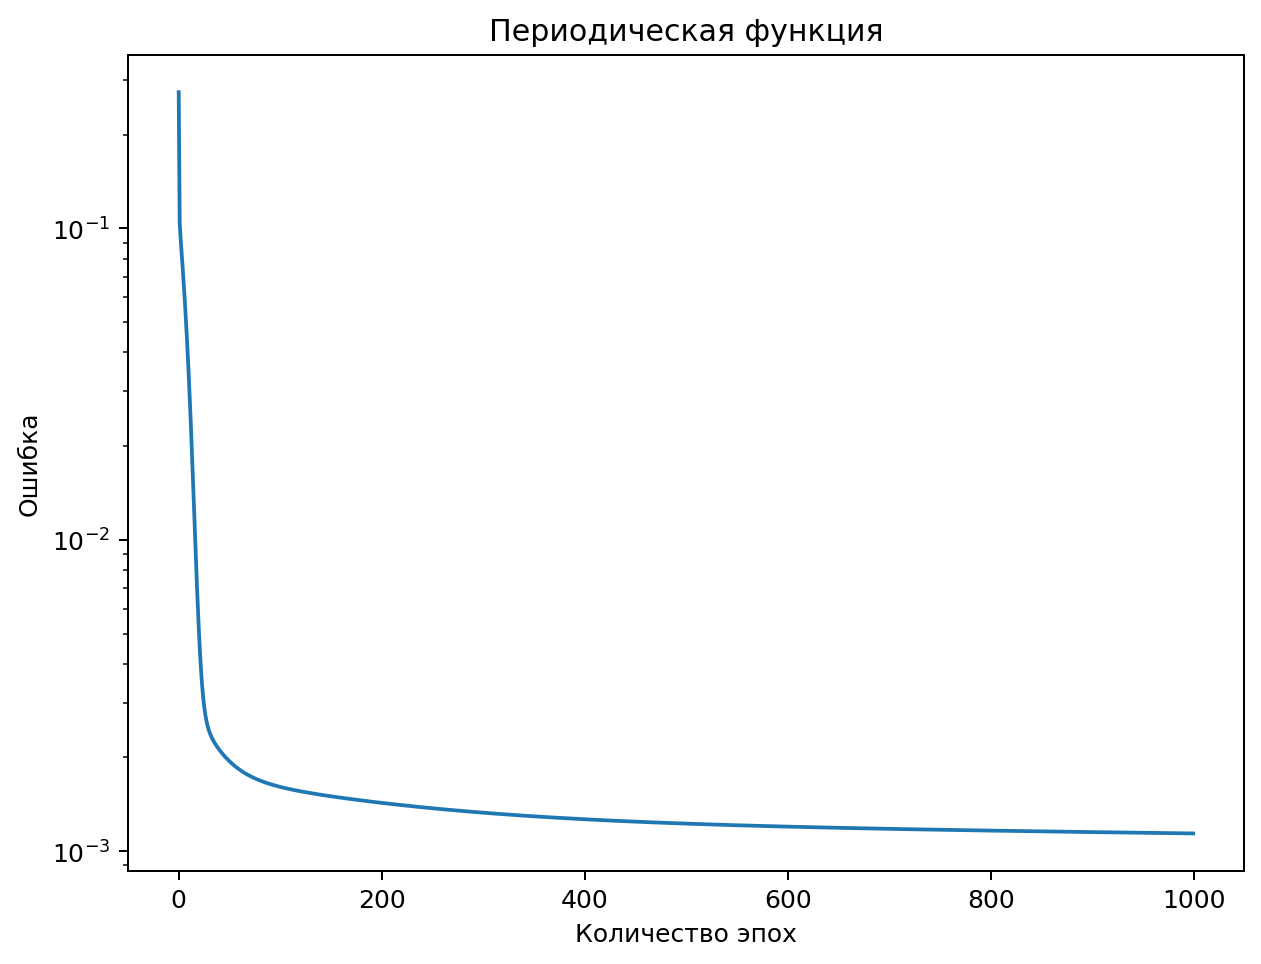

In [40]:
period_loss, period_metric = experiment(test_seq3, is_float=True)
plot_loss(period_loss, name='Периодическая функция')

4) Степенная
==

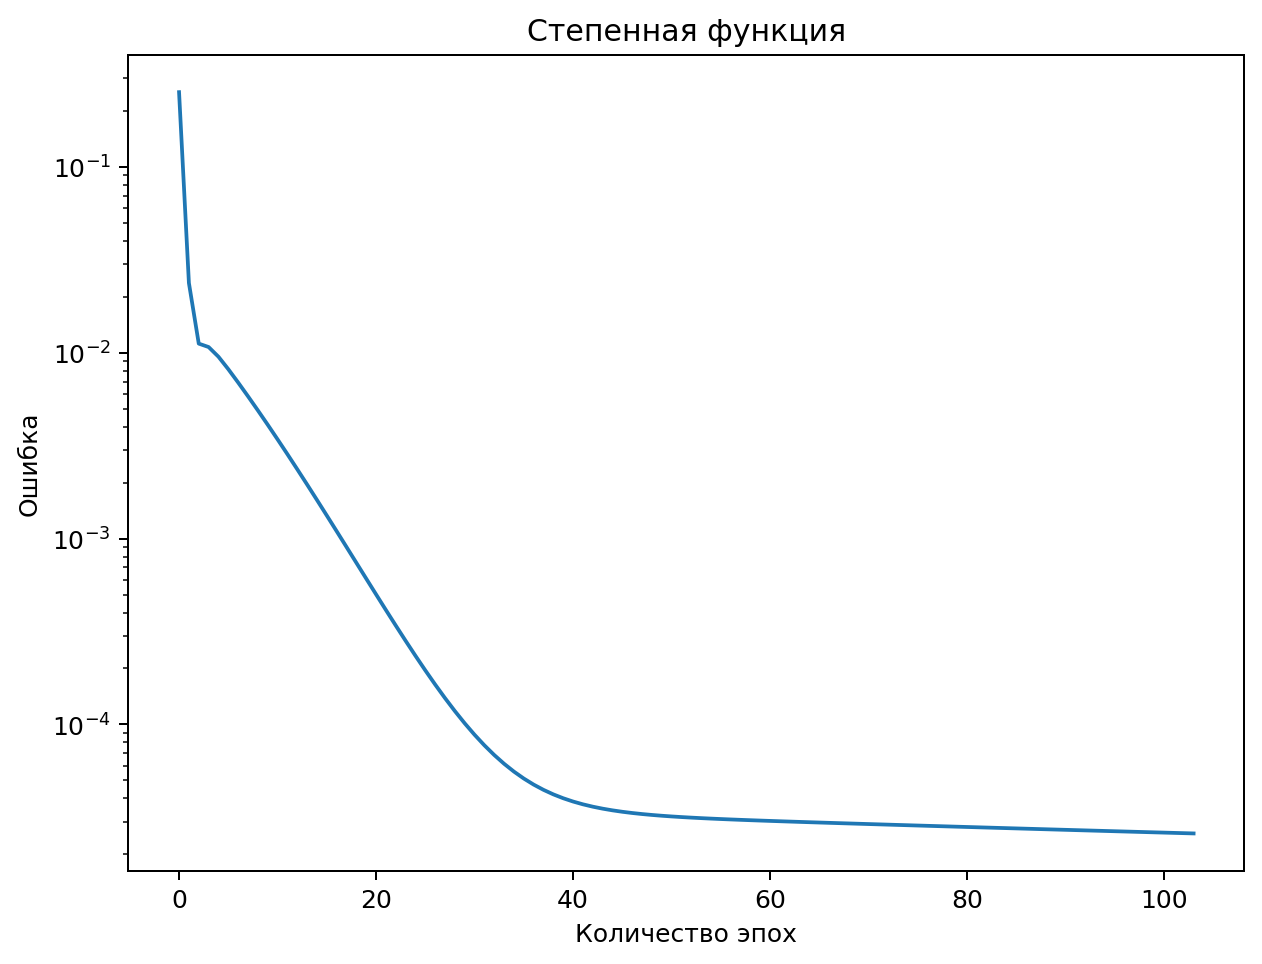

In [41]:
pow_loss, pow_metric = experiment(test_seq4)
plot_loss(pow_loss, name='Степенная функция')

5) Все графики ошибок
===

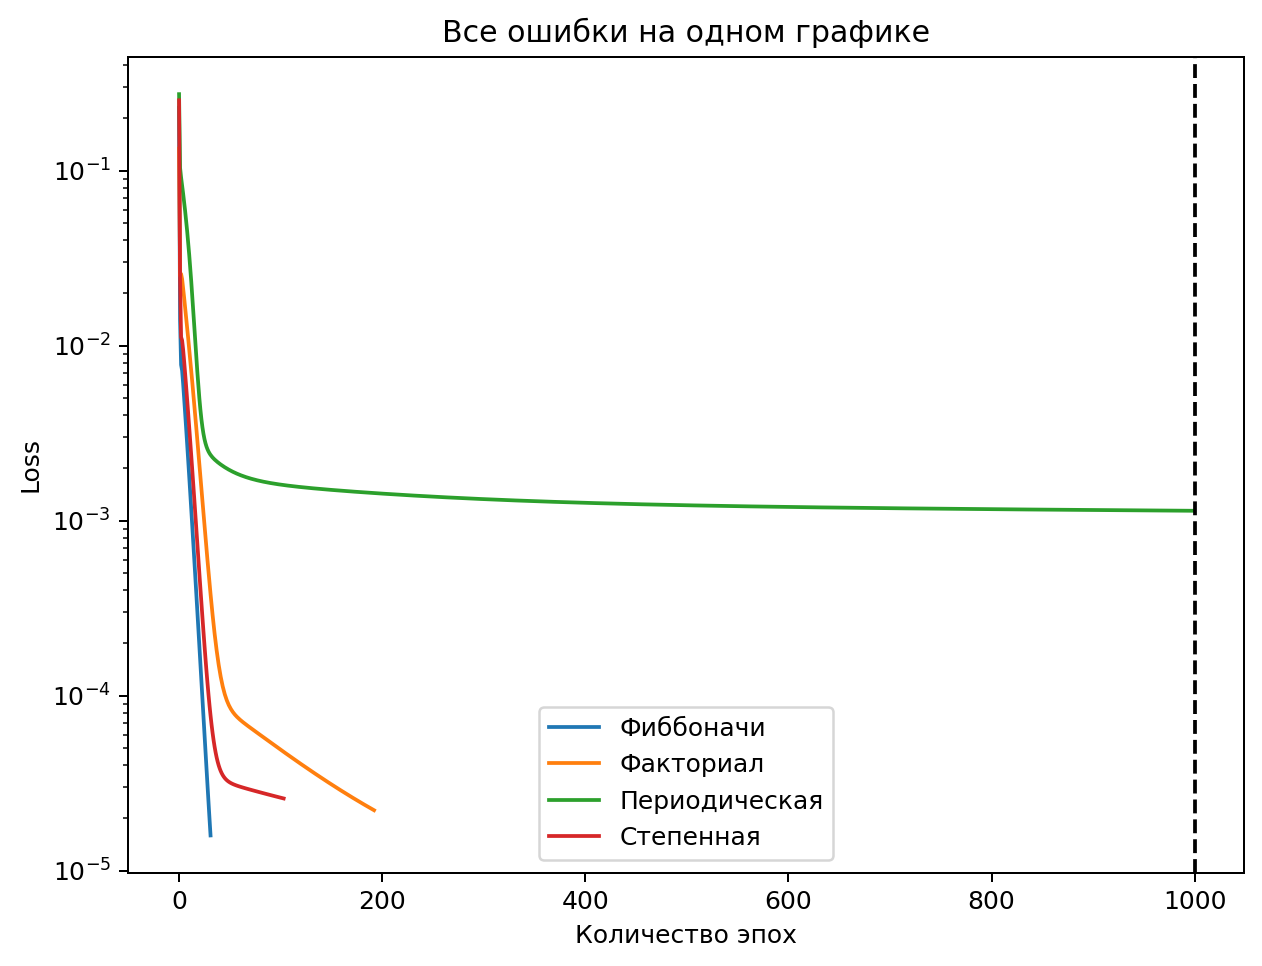

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=working_dpi)

ax.plot(fib_loss, label='Фиббоначи')
ax.plot(fac_loss, label='Факториал')
ax.plot(period_loss, label='Периодическая')
ax.plot(pow_loss, label='Степенная')

ax.set_yscale('log')

ax.set_title('Все ошибки на одном графике')
ax.set_ylabel('Loss')
ax.set_xlabel('Количество эпох')

ax.axvline(max_epoch, color='black', ls='--')

ax.legend()
plt.show()

6) Все графики MAPE
===

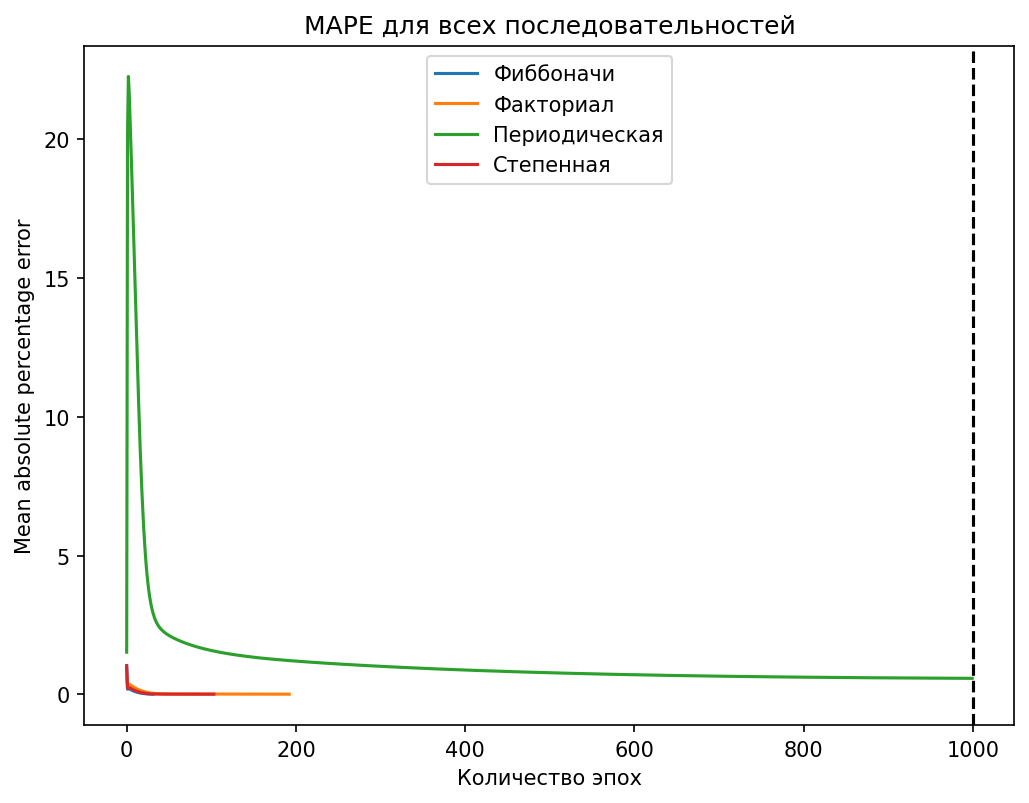

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)

ax.plot(fib_metric, label='Фиббоначи')
ax.plot(fac_metric, label='Факториал')
ax.plot(period_metric, label='Периодическая')
ax.plot(pow_metric, label='Степенная')


ax.set_title('MAPE для всех последовательностей')
ax.set_ylabel('Mean absolute percentage error')
ax.set_xlabel('Количество эпох')

ax.axvline(max_epoch, color='black', ls='--')

ax.legend()
plt.show()

7) Lrs Check Фиббоначи
==

In [50]:
lrs = [0.1, 0.001, 0.00001]
num_epochs = []

for lr in tqdm(lrs):
    
    trainer = Trainer(test_seq1, lr=lr)
    loss = 9999999
    mape = 1
    epoch = 0
    
    while mape > target_mape:
        loss, mape = trainer.training(epoch)
        epoch += 1 
        
        if epoch == max_epoch:
            break
            
    num_epochs.append(epoch)

100%|██████████| 3/3 [00:22<00:00,  7.61s/it]


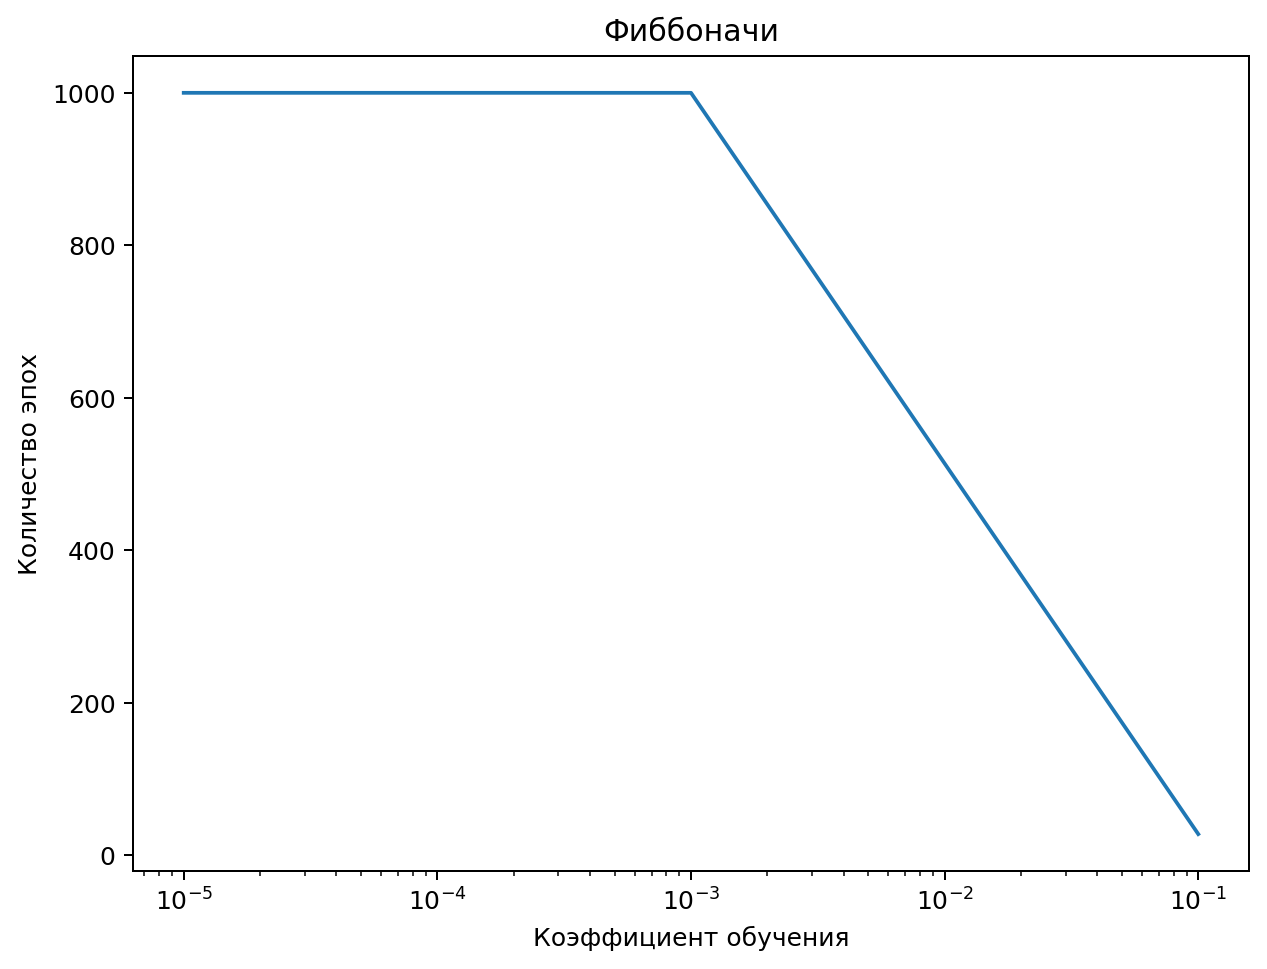

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=working_dpi)


ax.plot(lrs, num_epochs, label='Фиббоначи')

ax.set_xscale('log')

ax.set_title('Фиббоначи')
ax.set_xlabel('Коэффициент обучения')
ax.set_ylabel('Количество эпох')



plt.show()

8) Seq len check
===

In [52]:
seq_lens = [1, 2, 3, 5, 6]
num_epochs = []

for seq_len in tqdm(seq_lens):
    
    trainer = Trainer(test_seq1, seq_len=seq_len)
    loss = 9999999
    mape = 1
    epoch = 0
    
    while mape > target_mape:
        loss, mape = trainer.training(epoch)
        epoch += 1 
        
        if epoch == 3000:
            break
            
    num_epochs.append(epoch)

100%|██████████| 5/5 [00:50<00:00, 10.04s/it]


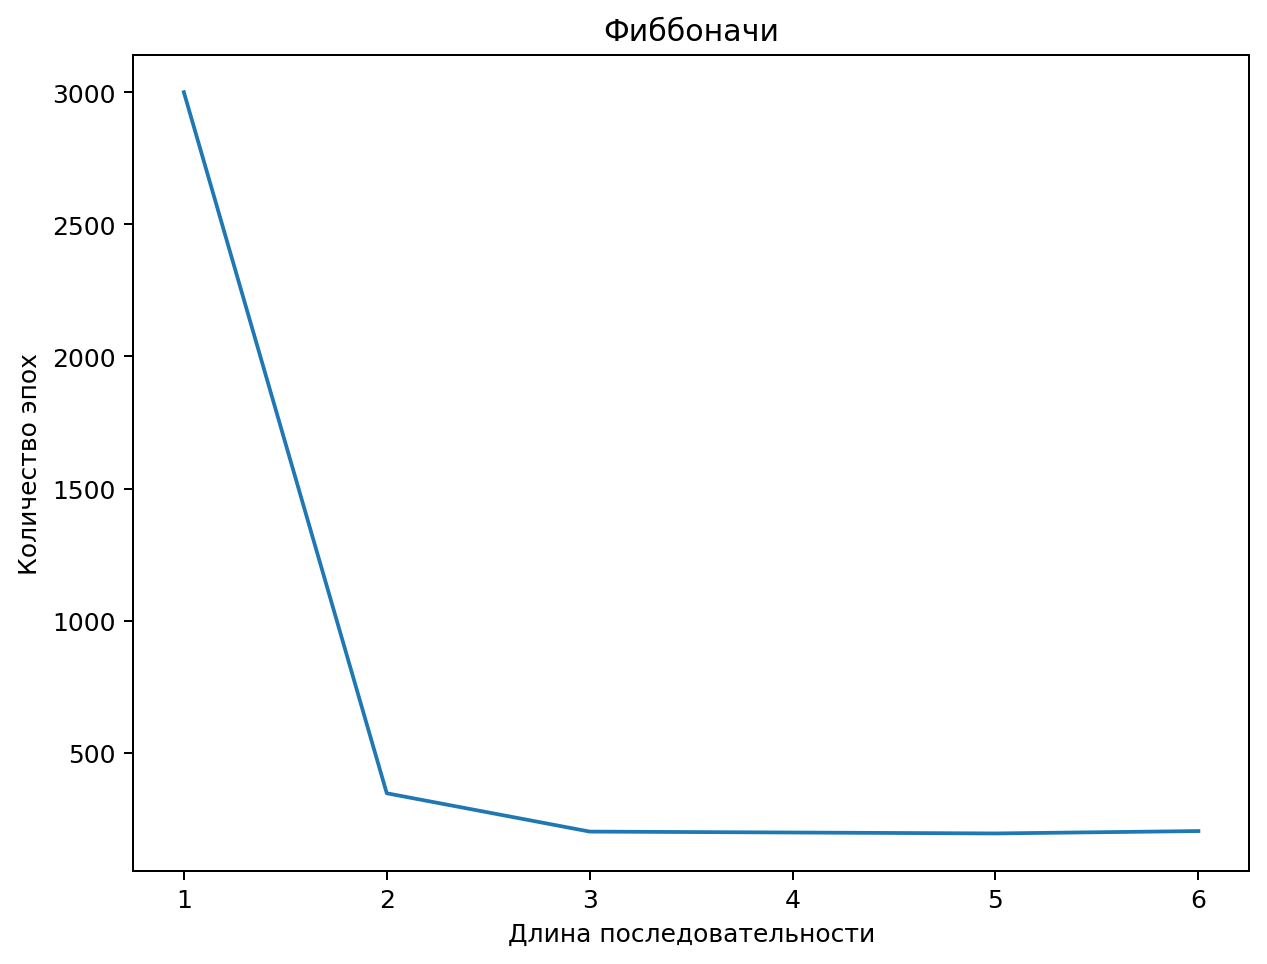

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=working_dpi)


ax.plot(seq_lens, num_epochs, label='Степенная')

#ax.set_yscale('log')

ax.set_title('Фиббоначи')
ax.set_xlabel('Длина последовательности')
ax.set_ylabel('Количество эпох')



plt.show()